<a href="https://colab.research.google.com/github/ziatdinovmax/AISTEM_WORKSHOP_2020/blob/main/Day01/01_ImSpec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Im2Spec models for prediction property (spectrum) from structure (image)

*  *Notebook prepared by Maxim Ziatdinov  (email: ziatdinovmax@gmail.com)*

*  *The experimental SPM data was collected by Kyle Kelley and the experimental STEM EELS data was collected by Jordan Hachtel and Kevin Roccapriore*

---

This notebook demosntrates usage of encoder-decoder neural networks for convering images (structure) to spectra (property). In the *im2spec* approach, the sub-images representing a local structure are “compressed” via a convolutional neural network architecture to the small number of latent variables, and the latter are “deconvoluted” to yield the spectra. The architecture of the *im2spec* model is straightforward. It consists of two parts: an encoder for embedding input images into a latent vector and a decoder for generating one-dimensional signals from the embedded features. The encoder part consists of three back-to-back two-dimensional convolutional layers, whereas the decoder part represents a cascade of one-dimensional dilated convolutions with dilation rates of 1, 2, 3, and 4. The dilated convolutions showed superior performance compared to regular convolutional blocks in the decoder. Each convolutional layer in both encoder and decoder parts is formed by running 64 filters (“kernels”) of size 3 on its input and is activated by a leaky rectified linear unit with a negative slope of 0.1. The batch normalization is applied after each activation to avoid overfitting and improve generalization to new data. The “bottleneck” layer for representing the latent vector is a fully connected layer with the number of neurons equal to the specified number of latent dimensions. 

<img src="https://drive.google.com/uc?export=view&id=18cvXfDdpy1Ij-p1T-jALa_nBZ0iRsalW" width=800 px><br><br>


The assumption is of course that there is only a small variability of spectral behaviour within each (sub)-image. Here we are going to apply the *imspec* approach to two different datasets: i) SPM BEPS dataset obtained by Kyle Kelley, and ii) STEM EELS dataset obtained by Jordan Hachtel. For the details of training/test data preparation, see [this](https://arxiv.org/pdf/2006.01374.pdf) and [this](https://arxiv.org/pdf/2009.09005.pdf) papers.


---






Install AtomAI:

In [1]:
!pip install atomai

     |████████████████████████████████| 112kB 13.6MB/s 
     |████████████████████████████████| 194kB 21.1MB/s 
     |████████████████████████████████| 870kB 25.4MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174964 sha256=01185dea61c7e9ab92b3b7e70866d7c9d74e776df5a4fc62f2a7bc5fc6de22a9
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b0139a692f6c265d399cab3aa097
Successfully built mendeleev


Imports:

In [2]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt

(Down)load training data:

## Application to SPM BEPS data

(Down)load training data:

In [3]:
!wget -O "imspec_data.npz" https://www.dropbox.com/s/os0weihai4l1kf8/im2spec.zip?dl=1

dataset = np.load('imspec_data.npz')
imgs = dataset['im2spec_images']
spectra = dataset['im2spec_spectra']
specval = dataset['im2spec_specval']

--2020-12-08 05:38:51--  https://www.dropbox.com/s/os0weihai4l1kf8/im2spec.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/os0weihai4l1kf8/im2spec.zip [following]
--2020-12-08 05:38:51--  https://www.dropbox.com/s/dl/os0weihai4l1kf8/im2spec.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9bbed5000557359c831bfbfe31.dl.dropboxusercontent.com/cd/0/get/BEp3HWEgsR2sjHa9hp5XfIP0AgUKch_HrBixfnsenbxQrcdWbSB4GtV8ApJhrHbdhcbpEIH81N0aS-4Pk8gtYAEyO7a3mQWz7MtFo4F8z0FUsrKu-mY3vMugjSIQsGqrsaU/file?dl=1# [following]
--2020-12-08 05:38:52--  https://uc9bbed5000557359c831bfbfe31.dl.dropboxusercontent.com/cd/0/get/BEp3HWEgsR2sjHa9hp5XfIP0AgUKch_HrBixfnsenbxQrcdWbSB4GtV8ApJhrHbdhcbpEIH81N0aS-4Pk8gtYAEyO7a3mQWz7MtFo4F8z0FUsrKu

Visualize individual image spectra pairs:

In [4]:
k = 12
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(imgs[k], cmap='gray')
ax2.plot(specval[0, :64], spectra[k])

Train-test split:

In [5]:
imgs_train, spectra_train, imgs_test, spectra_test = aoi.utils.data_split(imgs, spectra, format_out="torch_float")

Initialize and train ImSpec model:

In [6]:
in_dim = (16, 16)
out_dim = (64,)

model = aoi.models.ImSpec(in_dim, out_dim, latent_dim=10, seed=2)

model.fit(imgs_train, spectra_train, imgs_test, spectra_test,  # training data
          full_epoch=True, training_cycles=120, swa=True, batch_norm=True)  # training parameters

/usr/local/lib/python3.6/dist-packages/atomai/utils/preproc.py:89: UserWarning: Adding a channel dimension of 1 to training images
  UserWarning)
/usr/local/lib/python3.6/dist-packages/atomai/utils/preproc.py:94: UserWarning: Adding a channel dimension of 1 to test images
  UserWarning)
/usr/local/lib/python3.6/dist-packages/atomai/utils/preproc.py:99: UserWarning: Adding a channel dimension of 1 to training spectra
  UserWarning)
/usr/local/lib/python3.6/dist-packages/atomai/utils/preproc.py:104: UserWarning: Adding a channel dimension of 1 to test spectra
  UserWarning)


Epoch 1/120 ... Training loss: 26.0838 ... Test loss: 26.0949 ... GPU memory usage: 1317/16130
Epoch 2/120 ... Training loss: 24.926 ... Test loss: 24.4761 ... GPU memory usage: 1317/16130
Epoch 3/120 ... Training loss: 24.41 ... Test loss: 24.4638 ... GPU memory usage: 1317/16130
Epoch 4/120 ... Training loss: 24.0909 ... Test loss: 24.276 ... GPU memory usage: 1317/16130
Epoch 5/120 ... Training loss: 23.592 ... Test loss: 24.0892 ... GPU memory usage: 1317/16130
Epoch 6/120 ... Training loss: 23.1418 ... Test loss: 23.0869 ... GPU memory usage: 1317/16130
Epoch 7/120 ... Training loss: 22.6774 ... Test loss: 22.8582 ... GPU memory usage: 1317/16130
Epoch 8/120 ... Training loss: 22.353 ... Test loss: 22.0213 ... GPU memory usage: 1317/16130
Epoch 9/120 ... Training loss: 21.8289 ... Test loss: 21.9814 ... GPU memory usage: 1317/16130
Epoch 10/120 ... Training loss: 21.4346 ... Test loss: 21.1535 ... GPU memory usage: 1317/16130
Epoch 11/120 ... Training loss: 21.0785 ... Test loss: 

Make a prediction with the trained model:

In [7]:
prediction = model.predict(imgs_test, norm=False)

Batch 10/10
174 images were decoded in approximately 0.8948 seconds


Visualize predicted spectra for selected test images:

(note that predictions get improved as if we train longer)

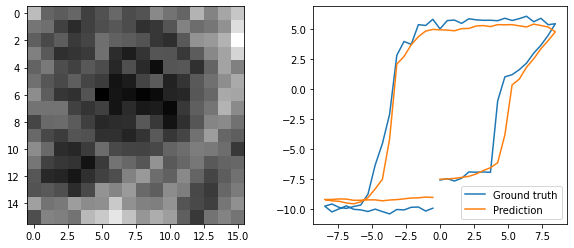

In [8]:
k = 150

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(imgs_test[k], cmap='gray', label="Input image")
ax2.plot(specval[0,:64], spectra_test[k], label="Ground truth")
ax2.plot(specval[0,:64], prediction[k], label="Prediction")
plt.legend()

## Application to STEM EELS data

(Down)load data:

In [9]:
!wget -O 'eels_imspec.npz' https://www.dropbox.com/s/n3gmmpr50igelyc/eels_imspec.npz?dl=1

--2020-12-08 05:49:05--  https://www.dropbox.com/s/n3gmmpr50igelyc/eels_imspec.npz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/n3gmmpr50igelyc/eels_imspec.npz [following]
--2020-12-08 05:49:05--  https://www.dropbox.com/s/dl/n3gmmpr50igelyc/eels_imspec.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc471381d40a30016540b3f03f58.dl.dropboxusercontent.com/cd/0/get/BErfONEC-MoEFHyKSBgBXBPfp7tpBRHSYJgubIXCqR4C6QgQGi06UPCRXkyVzEJNEwwBZpiSJ3vVuqpAAusZuN5yOdnU86qp3vJiUSp-tOsfzv_JlACzdGjIJxaPIcoN9jk/file?dl=1# [following]
--2020-12-08 05:49:06--  https://uc471381d40a30016540b3f03f58.dl.dropboxusercontent.com/cd/0/get/BErfONEC-MoEFHyKSBgBXBPfp7tpBRHSYJgubIXCqR4C6QgQGi06UPCRXkyVzEJNEwwBZpiSJ3vVuqpAAusZuN5yOdnU86qp3vJi

In [10]:
dataset = np.load('eels_imspec.npz')
imgs = dataset['imgs']
spectra = dataset['spectra']
specval = dataset['specval']

In [11]:
k = 12
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(imgs[k], cmap='gray')
ax2.plot(specval, spectra[k])

Train-test split:

In [12]:
imgs_train, spectra_train, imgs_test, spectra_test = aoi.utils.data_split(imgs, spectra, format_out="torch_float")

Initialize and train ImSpec model (same parameters as above):

In [13]:
in_dim = (16, 16)
out_dim = (2048,)

model = aoi.models.ImSpec(in_dim, out_dim, latent_dim=10, seed=2)

model.fit(imgs_train, spectra_train, imgs_test, spectra_test,  # training data
          full_epoch=True, training_cycles=120, swa=True, batch_norm=True)  # training parameters

/usr/local/lib/python3.6/dist-packages/atomai/utils/preproc.py:89: UserWarning: Adding a channel dimension of 1 to training images
  UserWarning)
/usr/local/lib/python3.6/dist-packages/atomai/utils/preproc.py:94: UserWarning: Adding a channel dimension of 1 to test images
  UserWarning)
/usr/local/lib/python3.6/dist-packages/atomai/utils/preproc.py:99: UserWarning: Adding a channel dimension of 1 to training spectra
  UserWarning)
/usr/local/lib/python3.6/dist-packages/atomai/utils/preproc.py:104: UserWarning: Adding a channel dimension of 1 to test spectra
  UserWarning)


Epoch 1/120 ... Training loss: 1.383 ... Test loss: 3.536 ... GPU memory usage: 2199/16130
Epoch 2/120 ... Training loss: 1.1435 ... Test loss: 0.9929 ... GPU memory usage: 2199/16130
Epoch 3/120 ... Training loss: 0.9658 ... Test loss: 0.8952 ... GPU memory usage: 2199/16130
Epoch 4/120 ... Training loss: 0.8185 ... Test loss: 0.7656 ... GPU memory usage: 2199/16130
Epoch 5/120 ... Training loss: 0.6953 ... Test loss: 0.6752 ... GPU memory usage: 2199/16130
Epoch 6/120 ... Training loss: 0.592 ... Test loss: 0.5663 ... GPU memory usage: 2199/16130
Epoch 7/120 ... Training loss: 0.5052 ... Test loss: 0.4966 ... GPU memory usage: 2199/16130
Epoch 8/120 ... Training loss: 0.4321 ... Test loss: 0.4036 ... GPU memory usage: 2199/16130
Epoch 9/120 ... Training loss: 0.3704 ... Test loss: 0.3586 ... GPU memory usage: 2199/16130
Epoch 10/120 ... Training loss: 0.3183 ... Test loss: 0.318 ... GPU memory usage: 2199/16130
Epoch 11/120 ... Training loss: 0.274 ... Test loss: 0.2726 ... GPU memor

Make prediciton on test data:

In [14]:
prediction = model.predict(imgs_test, norm=False)

Batch 10/10
408 images were decoded in approximately 1.8218 seconds


Visualize for selected test image: 

In [15]:
k = 100

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(imgs_test[k], cmap='gray', label="Input image")
ax2.plot(specval, spectra_test[k], label="Ground truth")
ax2.plot(specval, prediction[k], label="Prediction")
plt.legend()